# Generates PC plots in Supp Fig. 17

In [1]:
import os
import sys
import warnings
import multiprocessing as mp
import random
import pickle
import glob
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import scipy
import sklearn
from sklearn.decomposition import PCA, MiniBatchSparsePCA, SparsePCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from scipy.stats import wilcoxon
from scipy.stats import gaussian_kde

from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib import cm
from matplotlib.colors import ListedColormap


sys.path.append('../common')
import data_io_utils
import paths
import utils
import constants
import plot_style_utils

sys.path.append('../A003_policy_optimization/')
import A003_common
import models

sys.path.append('../A008_analyze_chip_1/')
import A008_common

import A011_common

%reload_ext autoreload
%autoreload 2

In [2]:
data_io_utils.sync_s3_path_to_local(os.path.join(paths.DATASETS_DIR, 'A011'))

## Load up relevant sequences

Firnberg sequences

In [3]:
seq_files = [paths.FIRNBERG_SPLIT_0_FILE, paths.FIRNBERG_SPLIT_1_FILE, paths.FIRNBERG_SPLIT_2_FILE]
for s in seq_files:
    data_io_utils.sync_s3_path_to_local(s, is_single_file=True)

df = pd.concat([pd.read_csv(sf) for sf in seq_files], axis=0)
print(df.shape)

firn_seqs = list(df['seq'])
firn_qfunc = np.array(df['quantitative_function'])

(5199, 2)


Random sequences

In [4]:
seq_file = 'A011f_BLAC_random_seqs.txt'
with open(seq_file) as f:
    rseqs = f.read().splitlines()
    
print(len(rseqs))

50000


Trajectories

In [5]:
with open('A011b_BLAC_example_trajectories.p', 'rb') as f:
    etraj = pickle.load(f)
    
min_traj_qfuncs = []
for k in etraj:
    traj_seqs, traj_qfuncs = zip(*etraj[k].items())
    min_traj_qfuncs.append(np.min(traj_qfuncs))
    print('%0.2f'%np.min(traj_qfuncs), k)

0.36 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3387
0.32 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-1827
0.39 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2924
0.36 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3273
0.31 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3046
0.16 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2078
0.08 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3010
0.30 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3499
0.30 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-103
0.22 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-725
0.30 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2183
0.28 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3290
0.23 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2482
0.36 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-193
0.37 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3202
0.36 BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-

SEQUENCE DESIGNS

In [6]:
# Generated in mlpe-gfp-pilot repository
lfe_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
        'A052e_BLAC_log_fold_enrichment.csv')
data_io_utils.sync_s3_path_to_local(lfe_data_file, is_single_file=True)

df = pd.read_csv(lfe_data_file)
q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
design_df = df.merge(q, left_index=True, right_index=True)

## Load up what we need to generate reps given a list of sequences

In [7]:
PROT = 'BLAC'

In [8]:
load_seq2rep_and_pca = A011_common.load_seq2rep_and_pca
generate_reps = A011_common.generate_reps

In [9]:
s2r_et1, _ = load_seq2rep_and_pca(PROT, 'et_global_init_1', load_pca=False)
s2r_rand, _ = load_seq2rep_and_pca(PROT, 'random_init', load_pca=False)

/notebooks/analysis/common/../../data/s3/datasets/A011/BLAC_seq2rep_et_global_init_1_v2.p
/notebooks/analysis/common/../../data/s3/datasets/A011/BLAC_seq2rep_random_init_v2.p


## Visualize

In [10]:
PLOT_TRAJECTORIES = False

In [11]:
CMAP = ListedColormap(plot_style_utils.SEQ_PALETTE[:60])
LP = 1
UP = 99

def window_smooth(x, qfunc, lp=LP, up=UP):
    bins = np.linspace(np.percentile(x,LP), np.percentile(x,UP), 100)
    
    qacc = []
    for i in range(len(bins)-1):
        mask = np.logical_and(x > bins[i], x <= bins[i+1])
        qacc.append(np.mean(qfunc[mask]))
        
    qacc = np.array(qacc)
    qacc_x = (bins[1:] + bins[:-1])/2
    
    return qacc_x, qacc

def set_up_for_plotting(s, qfunc, use_best_angle=True):
    #s = StandardScaler().fit_transform(s)[:,:2] # Scale the PCs for visualization
    s = s[:,:2]
    
    lp = LP
    up = UP
      
    if use_best_angle:
        # Generate line to plot, to illustrate qfunc accumulation
        xx = np.percentile(s[:,0], [lp, up])

        pos_mask = qfunc > 0.9
        neg_mask = qfunc < 0.1

        mpos = np.mean(s[pos_mask],axis=0)
        mneg = np.mean(s[neg_mask], axis=0)
        diff = mpos - mneg

        slope = diff[1]/diff[0]
        intercept = np.mean(s[:,1] - slope*s[:,0])

        yy = xx*slope + intercept

        # Generate rotatation matrix. This is to internally rotate the point cloud
        # such that we're lined upwith the qfucnc accumulation line.
        # We can then calculate qfunc accumulation along the rotated x-axis.
        theta = np.arctan(slope)
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        sr = s.dot(R)

        # Now calculate qfunc accumulation along rotated x-axis
        qacc_x, qacc = window_smooth(sr[:,0], qfunc, lp=lp, up=up)

        sort_dir = np.sign(np.corrcoef(sr[:,0], qfunc)[0,1])
        sidx = np.argsort(sr[:,0])
        qacc_x_perf, qacc_perf = window_smooth(sr[sidx,0], sort_dir*np.sort(sort_dir*qfunc), lp=lp, up=up)
    else:
        xx = None
        yy = None
        
        qacc_x, qacc = window_smooth(s[:,0], qfunc, lp=lp, up=up)
        
        sort_dir = np.sign(np.corrcoef(s[:,0], qfunc)[0,1])
        sidx = np.argsort(s[:,0])
        qacc_x_perf, qacc_perf = window_smooth(s[sidx,0], sort_dir*np.sort(sort_dir*qfunc), lp=lp, up=up)
        
                        
    return s, xx, yy, qacc_x, qacc, qacc_x_perf, qacc_perf

def auto_set_xy_lims(s, ax, buffer=0.3, set_x_only=False):
    std_x = np.std(s[:,0])
    std_y = np.std(s[:,1])
    
    xp = np.percentile(s[:,0], [LP, UP])
    xlim = [xp[0]-buffer*std_x, xp[1]+buffer*std_x]
    
    yp = np.percentile(s[:,1], [LP, UP])
    ylim = [yp[0]-buffer*std_y, yp[1]+buffer*std_y]
    
    ax.set_xlim(xlim)
    
    if not set_x_only:
        ax.set_ylim(ylim)
    

def firn_manifold_plot(s, qfunc, auto_lim=True, use_best_angle=True, exponentiate=False):
    cmap = CMAP 
    #CLIM = np.percentile(qfunc, [5, 100])
    
    if exponentiate:
        qfunc = 10**qfunc

    assert s.shape[0] == len(firn_seqs)
    assert len(qfunc) == len(firn_seqs)
    
    s, xx, yy, qacc_x, qacc, _, qacc_perf = set_up_for_plotting(s, qfunc, use_best_angle=use_best_angle)
    
    fig1 = plt.figure(figsize=(4,4))
    plot_style_utils.prettify_ax(plt.gca())
    plt.scatter(s[:,0], s[:,1], c=qfunc, s=5, alpha=0.5, cmap=cmap)
    if use_best_angle:
        plt.plot(xx, yy, '-r', linewidth=4)
    if auto_lim:
        auto_set_xy_lims(s, fig1.gca())
    plt.xticks()
    plt.yticks()
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    #plt.plot(s[WT_IDX,0], s[WT_IDX,1], 'or')
    #plt.show()
    
    #plt.clim(CLIM)
    print('CLIM:', plt.gci().get_clim())
    
    fig2 = plt.figure(figsize=(4,1))
    plot_style_utils.prettify_ax(plt.gca())
    #plt.plot(qacc_x, qacc_perf, '-', color=plot_style_utils.GRAY, linewidth=4)
    plt.plot(qacc_x, qacc, '-k', linewidth=4)
    
    if auto_lim:
        auto_set_xy_lims(s, fig2.gca(), set_x_only=True)
        
    if exponentiate:
        plt.yticks([10**1.0])
        plt.ylim([10**0,10**1.02])
    else:
        plt.yticks([1.0])
        plt.ylim([0,1.02])
    #plt.xlim(np.min(qacc_x), np.max(qacc_x))
    plt.gca().set_xticks([])
    plt.gca().set_yticklabels([])
    plt.grid(True)
    #plt.show()
    
    return fig1, fig2
    
    
def plot_trajectory(traj_name, fig, dr, gr, color=[1,0,1]):
    traj = etraj[traj_name]
    traj_seqs, traj_qfuncs = zip(*traj.items())

    traj_seqs = np.array(traj_seqs)
    traj_qfuncs = np.array(traj_qfuncs)

    stop_idx = np.argmax(traj_qfuncs).reshape(-1)[0]
    traj_seqs = traj_seqs[:stop_idx+1]
    traj_qfuncs = traj_qfuncs[:stop_idx+1]
    
    print('N-steps:', len(traj_seqs))

    traj_s = dr.transform(gr(traj_seqs))
    
    line = fig.gca().plot(traj_s[:,0], traj_s[:,1], '-', linewidth=3, color=color)
    fig.gca().plot(traj_s[0,0], traj_s[0,1], 'o', color=color)
    #add_arrow(line[0])
    
    
def make_fixed_nmut_func_nonfunc_dist_plot(s, mut_count, use_sym_perc=False):
    double_mask = nmut == mut_count

    double_s0 = s[double_mask,0]
    double_qfunc = firn_qfunc[double_mask]

    hf = double_qfunc > np.percentile(double_qfunc, 95)
    lf = double_qfunc < np.percentile(double_qfunc, 5)

    print(np.sum(hf))
    print(np.sum(lf))

    fig = plt.figure(figsize=(4,4))
    plot_style_utils.prettify_ax(plt.gca())
    sns.kdeplot(double_s0[hf], color=plot_style_utils.CAT_PALETTE[0], shade=True, linewidth=4)
    sns.kdeplot(double_s0[lf], color=plot_style_utils.CAT_PALETTE[1], shade=True, linewidth=4)
    if use_sym_perc:
        plt.xlim([np.percentile(double_s0[hf], 0.1)-1, np.percentile(double_s0[lf], 99.9)+1])
    else:
        plt.xlim([np.percentile(double_s0[hf], 0)-5, np.percentile(double_s0[lf], 99)])
    #plt.legend(['Functional double mutants', 'Non-functional double mutants'])
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    return fig

compute_data_for_low_dim_manifold_viz = A011_common.compute_data_for_low_dim_manifold_viz
density_scatter = A011_common.density_scatter
log_like_scatter = A011_common.log_like_scatter
generate_pc_info_for_rep = A011_common.generate_pc_info_for_rep
plot_single_variant = A011_common.plot_single_variant
grab_top_designs_for_model = A011_common.grab_top_designs_for_model

In [12]:
def generate_plots_for_rep(pc_info, model_name):
    s = pc_info['s']
    dr = pc_info['dr']
    gr = pc_info['gr']
    log_likes = pc_info['log_likes']
    
    print('Manifold plot')
    f1, f2 = firn_manifold_plot(s, firn_qfunc, auto_lim=True, use_best_angle=False, exponentiate=True)
    print('Pearson:', scipy.stats.pearsonr(s[:,0], firn_qfunc))
    print('Spearman:', scipy.stats.spearmanr(s[:,0], firn_qfunc))

    # Plot WT
    plot_single_variant(f1, constants.BETA_LAC_AA_SEQ, 'BLAC', gr, dr, color='k')

    top_design_df = grab_top_designs_for_model(design_df, model_name, PROT, n=10)
    display(top_design_df)
    for seq in top_design_df['seq']: ###
        plot_single_variant(f1, seq, '', gr, dr, color=[1,0,1], markerfacecolor=None)

    if PLOT_TRAJECTORIES:
        pass 
    
    plt.show()
    
    
    print('Fixed n-mut differences')
    f3 = None

    
    print('Log-like scatter')
    f4 = log_like_scatter(s, log_likes)
    plt.show()

    return f1,f2,f3,f4

def save_plots(f1,f2,f3,f4, model_name):
    plot_style_utils.save_for_pub(fig=f1, path='figures/%s_%s_low_dim_manifold'%(PROT, model_name), include_vector=False)
    plot_style_utils.save_for_pub(fig=f2, path='figures/%s_%s_low_dim_manifold_qfunc_acc'%(PROT, model_name))
    #plot_style_utils.save_for_pub(fig=f3, path='figures/%s_%s_single_mutation_s0_dist'%(PROT, model_name))
    plot_style_utils.save_for_pub(fig=f4, path='figures/%s_%s_seq_likelihood_scatter'%(PROT, model_name))

In [13]:
plot_style_utils.set_pub_plot_context()

## Random Init 1

In [14]:
pc_info = generate_pc_info_for_rep(s2r_rand, rseqs, firn_seqs)

Generating basis reps
Generating viz reps
Fitting basis reps with PCA
Transforming viz reps with learned PCA


Manifold plot
CLIM: (1.0, 14.106701608917508)
Pearson: (0.19687223702578668, 1.3736807079201019e-46)
Spearman: SpearmanrResult(correlation=0.25023145481717113, pvalue=4.703716945150841e-75)


,lfe_250,lfe_1000,lfe_2500,lfe_5000,rep1_250,rep1_1000,rep1_2500,rep1_5000,rep2_250,rep2_1000,...,ligated_gene,ligated_gene_translated,n_mut_rel_wt,oligo_len,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
3881,0.932493,1.570877,2.021376,-1.292062,0.954985,1.570877,2.021376,2.043516,0.932493,1.593673,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,24,3,3764e943,seq_idx_250_1698,
3882,0.932493,1.570877,2.021376,-1.292062,0.954985,1.570877,2.021376,2.043516,0.932493,1.593673,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_790_850,
5590,0.944451,1.551612,-0.410453,-1.509188,0.944451,1.551612,-0.410453,-1.075821,0.984285,1.630753,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_250_3052,
2226,0.917421,1.532572,1.804845,-1.314945,0.930915,1.532572,2.687862,2.851234,0.917421,1.568707,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,2,341cf5c,seq_idx_250_93,
3880,0.970927,1.524447,-0.452656,-1.286265,0.970927,1.524447,-0.452656,-0.796149,0.978417,1.588803,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_250_1405,
6201,0.876143,1.494720,1.506824,-1.599609,0.969423,1.561617,1.661217,-0.922969,0.876143,1.494720,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_250_1263,
3884,0.877740,1.447303,1.657817,-1.304250,0.877740,1.447303,1.657817,-0.974050,0.938827,1.583659,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_464_773,


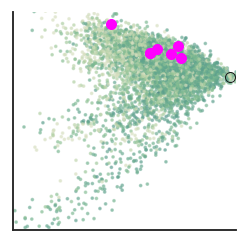

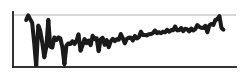

Fixed n-mut differences
Log-like scatter
Pearson R 0.6087272171962813
Spearman rho 0.6177969329765615


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


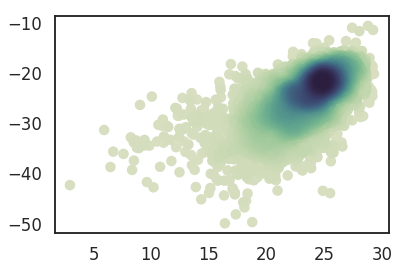

In [15]:
f1,f2,f3,f4 = generate_plots_for_rep(pc_info, 'ET_Random_Init_1')

In [16]:
save_plots(f1,f2,f3,f4, 'ET_Random_Init_1')

## Evotuned UniRep 1

In [17]:
pc_info = generate_pc_info_for_rep(s2r_et1, rseqs, firn_seqs)

Generating basis reps
Generating viz reps
Fitting basis reps with PCA
Transforming viz reps with learned PCA


Manifold plot
CLIM: (1.0, 14.106701608917508)
Pearson: (0.4388573896981861, 9.49144844542243e-244)
Spearman: SpearmanrResult(correlation=0.45241248795019484, pvalue=8.922655315940299e-261)


,lfe_250,lfe_1000,lfe_2500,lfe_5000,rep1_250,rep1_1000,rep1_2500,rep1_5000,rep2_250,rep2_1000,...,ligated_gene,ligated_gene_translated,n_mut_rel_wt,oligo_len,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
3881,0.932493,1.570877,2.021376,-1.292062,0.954985,1.570877,2.021376,2.043516,0.932493,1.593673,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,24,3,3764e943,seq_idx_250_1698,
3882,0.932493,1.570877,2.021376,-1.292062,0.954985,1.570877,2.021376,2.043516,0.932493,1.593673,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_790_850,
5590,0.944451,1.551612,-0.410453,-1.509188,0.944451,1.551612,-0.410453,-1.075821,0.984285,1.630753,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_250_3052,
2226,0.917421,1.532572,1.804845,-1.314945,0.930915,1.532572,2.687862,2.851234,0.917421,1.568707,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,2,341cf5c,seq_idx_250_93,
3880,0.970927,1.524447,-0.452656,-1.286265,0.970927,1.524447,-0.452656,-0.796149,0.978417,1.588803,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_250_1405,
6201,0.876143,1.494720,1.506824,-1.599609,0.969423,1.561617,1.661217,-0.922969,0.876143,1.494720,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_250_1263,
3884,0.877740,1.447303,1.657817,-1.304250,0.877740,1.447303,1.657817,-0.974050,0.938827,1.583659,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_464_773,


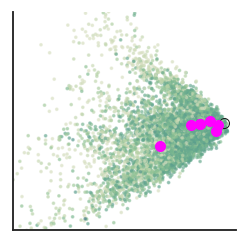

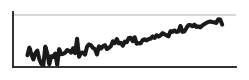

Fixed n-mut differences
Log-like scatter
Pearson R 0.8038654713731793
Spearman rho 0.7548405889496119


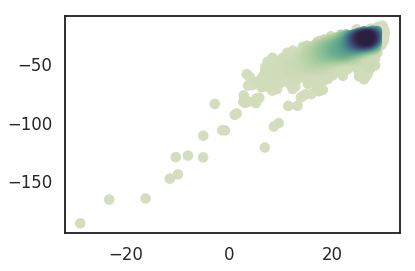

In [18]:
f1,f2,f3,f4 = generate_plots_for_rep(pc_info, 'ET_Global_Init_1')

In [19]:
save_plots(f1,f2,f3,f4, 'ET_Global_Init_1')

## One-hot

In [20]:
np.random.seed(4)
random.seed(4)

s, dr, gr, log_likes = compute_data_for_low_dim_manifold_viz(
    rseqs,
    firn_seqs,
    lambda x: (utils.encode_aa_seq_list_as_matrix_of_flattened_one_hots(x), np.random.randn(len(firn_seqs))) 
)

s[:,0] = -s[:,0]

pc_info = {
    's': s,
    'dr': dr,
    'gr': gr,
    'log_likes': log_likes
}

Generating basis reps
Generating viz reps
Fitting basis reps with PCA
Transforming viz reps with learned PCA


Manifold plot
CLIM: (1.0, 14.106701608917508)
Pearson: (0.03067630760889734, 0.02697523822382952)
Spearman: SpearmanrResult(correlation=0.03729812376444953, pvalue=0.0071529893439173835)


,lfe_250,lfe_1000,lfe_2500,lfe_5000,rep1_250,rep1_1000,rep1_2500,rep1_5000,rep2_250,rep2_1000,...,ligated_gene,ligated_gene_translated,n_mut_rel_wt,oligo_len,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
3881,0.932493,1.570877,2.021376,-1.292062,0.954985,1.570877,2.021376,2.043516,0.932493,1.593673,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,24,3,3764e943,seq_idx_250_1698,
3882,0.932493,1.570877,2.021376,-1.292062,0.954985,1.570877,2.021376,2.043516,0.932493,1.593673,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_790_850,
5590,0.944451,1.551612,-0.410453,-1.509188,0.944451,1.551612,-0.410453,-1.075821,0.984285,1.630753,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_250_3052,
2226,0.917421,1.532572,1.804845,-1.314945,0.930915,1.532572,2.687862,2.851234,0.917421,1.568707,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,2,341cf5c,seq_idx_250_93,
3880,0.970927,1.524447,-0.452656,-1.286265,0.970927,1.524447,-0.452656,-0.796149,0.978417,1.588803,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_250_1405,
6201,0.876143,1.494720,1.506824,-1.599609,0.969423,1.561617,1.661217,-0.922969,0.876143,1.494720,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_250_1263,
3884,0.877740,1.447303,1.657817,-1.304250,0.877740,1.447303,1.657817,-0.974050,0.938827,1.583659,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.0,293.0,ET_Global_Init_1,96,0,3ea5f6e,seq_idx_464_773,


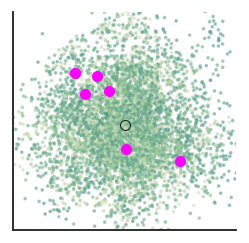

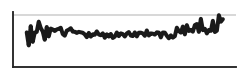

Fixed n-mut differences
Log-like scatter
Pearson R 0.007959728370925099
Spearman rho 0.008692885956196173


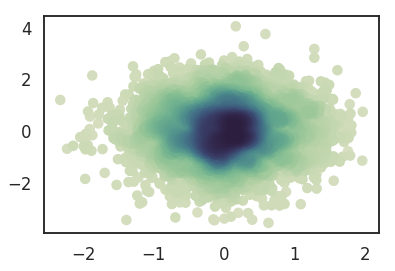

In [21]:
f1,f2,f3,f4 = generate_plots_for_rep(pc_info, 'OneHot')

In [22]:
save_plots(f1,f2,f3,f4, 'OneHot')

## Colorbar

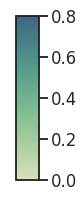

In [23]:
CLIM = [1, 14.1]
clip_to = 10

pallete_clip_idx = round(len(plot_style_utils.SEQ_PALETTE)*(clip_to - CLIM[0])/(CLIM[1] - CLIM[0]))

fig, ax = plt.subplots(figsize=(0.4,6))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, 
    cmap=ListedColormap(plot_style_utils.SEQ_PALETTE[:pallete_clip_idx]),
    norm=None,
    orientation='vertical')

ticks = np.linspace(CLIM[0], clip_to, num=6)
min_max_ticks = (ticks - 1)/(10 - 1) # 10 = WT fitness = 10**1 (under exponentiation)
cb1.ax.set_yticklabels(np.around(min_max_ticks,1))
plt.show()

plot_style_utils.save_for_pub(fig, path='figures/BLAC_manifold_colorbar')